In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Initial Exploration

In [3]:
df = pd.read_csv('master.csv')
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9   gdp_for_year ($)    27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [5]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [6]:
df.shape

(27820, 12)

## Data Cleaning and Preprocessing

In [20]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
gdp_for_year ($)          0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [7]:
df.drop(['HDI for year', 'country-year'], axis=1, inplace=True)
df['gdp_for_year ($)'] = df['gdp_for_year ($)'].str.replace(',', '').astype(float)

In [ ]:
df.columns  

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

## Data Distribution Analysis

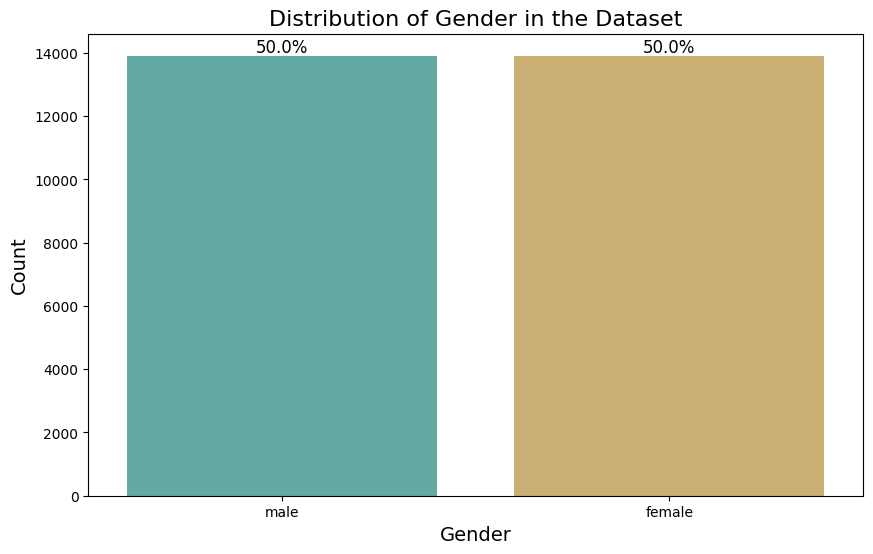

In [ ]:
# Distribution of Gender in the Dataset
gender_counts = df['sex'].value_counts()
gender_percent = df['sex'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sex', data=df, palette=['#5ab4ac', '#d8b365'])
plt.title('Distribution of Gender in the Dataset', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add percentages
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 100,
            f'{gender_percent.values[i]:.1f}%',
            ha="center", fontsize=12)

plt.show()

<Figure size 1400x800 with 0 Axes>

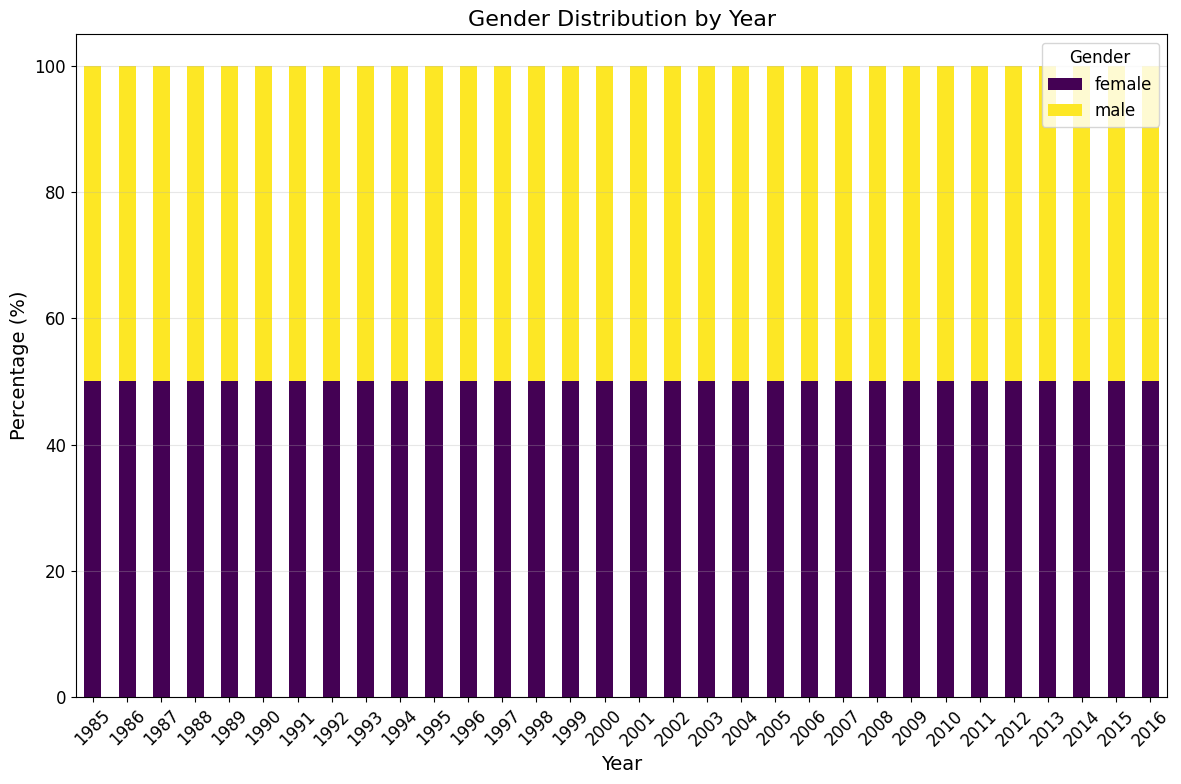

In [ ]:
# check if gender distribution is equal across years
gender_by_year = pd.crosstab(df['year'], df['sex'], normalize='index') * 100

plt.figure(figsize=(14, 8))
gender_by_year.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Gender Distribution by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

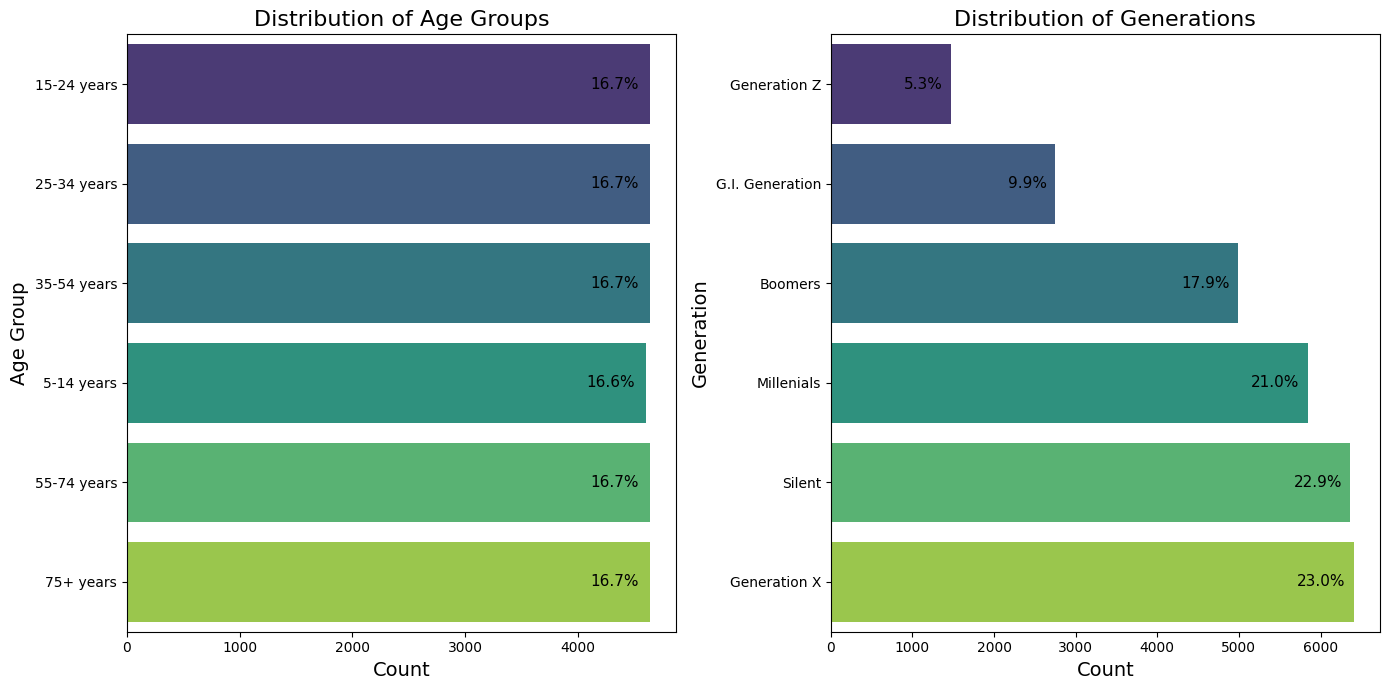

In [ ]:
# Distribution of Age Groups
age_counts = df['age'].value_counts().sort_index()
age_percent = df['age'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(14, 7))
ax1 = plt.subplot(121)
sns.countplot(y='age', data=df, order=age_counts.index, palette='viridis')
plt.title('Distribution of Age Groups', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Age Group', fontsize=14)

for i, p in enumerate(ax1.patches):
    width = p.get_width()
    plt.text(width - 100, p.get_y() + p.get_height()/2, f'{age_percent.values[i]:.1f}%',
             ha='right', va='center', fontsize=11)

# Distribution of Generations
gen_counts = df['generation'].value_counts().sort_values()
gen_percent = df['generation'].value_counts(normalize=True).sort_values() * 100

plt.subplot(122)
ax2 = sns.countplot(y='generation', data=df, order=gen_counts.index, palette='viridis')
plt.title('Distribution of Generations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Generation', fontsize=14)

for i, p in enumerate(ax2.patches):
    width = p.get_width()
    plt.text(width - 100, p.get_y() + p.get_height()/2, f'{gen_percent.values[i]:.1f}%',
             ha='right', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [42]:
df['country'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [47]:
continent_map = {
    'Albania': 'Europe',
    'Antigua and Barbuda': 'North America',
    'Argentina': 'South America',
    'Armenia': 'Asia',
    'Aruba': 'North America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Asia',
    'Bahamas': 'North America',
    'Bahrain': 'Asia',
    'Barbados': 'North America',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Belize': 'North America',
    'Bosnia and Herzegovina': 'Europe',
    'Brazil': 'South America',
    'Bulgaria': 'Europe',
    'Cabo Verde': 'Africa',
    'Canada': 'North America',
    'Chile': 'South America',
    'Colombia': 'South America',
    'Costa Rica': 'North America',
    'Croatia': 'Europe',
    'Cuba': 'North America',
    'Cyprus': 'Asia',
    'Czech Republic': 'Europe',
    'Denmark': 'Europe',
    'Dominica': 'North America',
    'Ecuador': 'South America',
    'El Salvador': 'North America',
    'Estonia': 'Europe',
    'Fiji': 'Oceania',
    'Finland': 'Europe',
    'France': 'Europe',
    'Georgia': 'Asia',
    'Germany': 'Europe',
    'Greece': 'Europe',
    'Grenada': 'North America',
    'Guatemala': 'North America',
    'Guyana': 'South America',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'Ireland': 'Europe',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Jamaica': 'North America',
    'Japan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kiribati': 'Oceania',
    'Kuwait': 'Asia',
    'Kyrgyzstan': 'Asia',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Macau': 'Asia',
    'Maldives': 'Asia',
    'Malta': 'Europe',
    'Mauritius': 'Africa',
    'Mexico': 'North America',
    'Mongolia': 'Asia',
    'Montenegro': 'Europe',
    'Netherlands': 'Europe',
    'New Zealand': 'Oceania',
    'Nicaragua': 'North America',
    'Norway': 'Europe',
    'Oman': 'Asia',
    'Panama': 'North America',
    'Paraguay': 'South America',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Puerto Rico': 'North America',
    'Qatar': 'Asia',
    'Republic of Korea': 'Asia',
    'Romania': 'Europe',
    'Russian Federation': 'Europe',
    'Saint Kitts and Nevis': 'North America',
    'Saint Lucia': 'North America',
    'Saint Vincent and Grenadines': 'North America',
    'San Marino': 'Europe',
    'Serbia': 'Europe',
    'Seychelles': 'Africa',
    'Singapore': 'Asia',
    'Slovakia': 'Europe',
    'Slovenia': 'Europe',
    'South Africa': 'Africa',
    'Spain': 'Europe',
    'Sri Lanka': 'Asia',
    'Suriname': 'South America',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Thailand': 'Asia',
    'Trinidad and Tobago': 'North America',
    'Turkey': 'Asia',
    'Turkmenistan': 'Asia',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Asia',
    'United Kingdom': 'Europe',
    'United States': 'North America',
    'Uruguay': 'South America',
    'Uzbekistan': 'Asia'
}

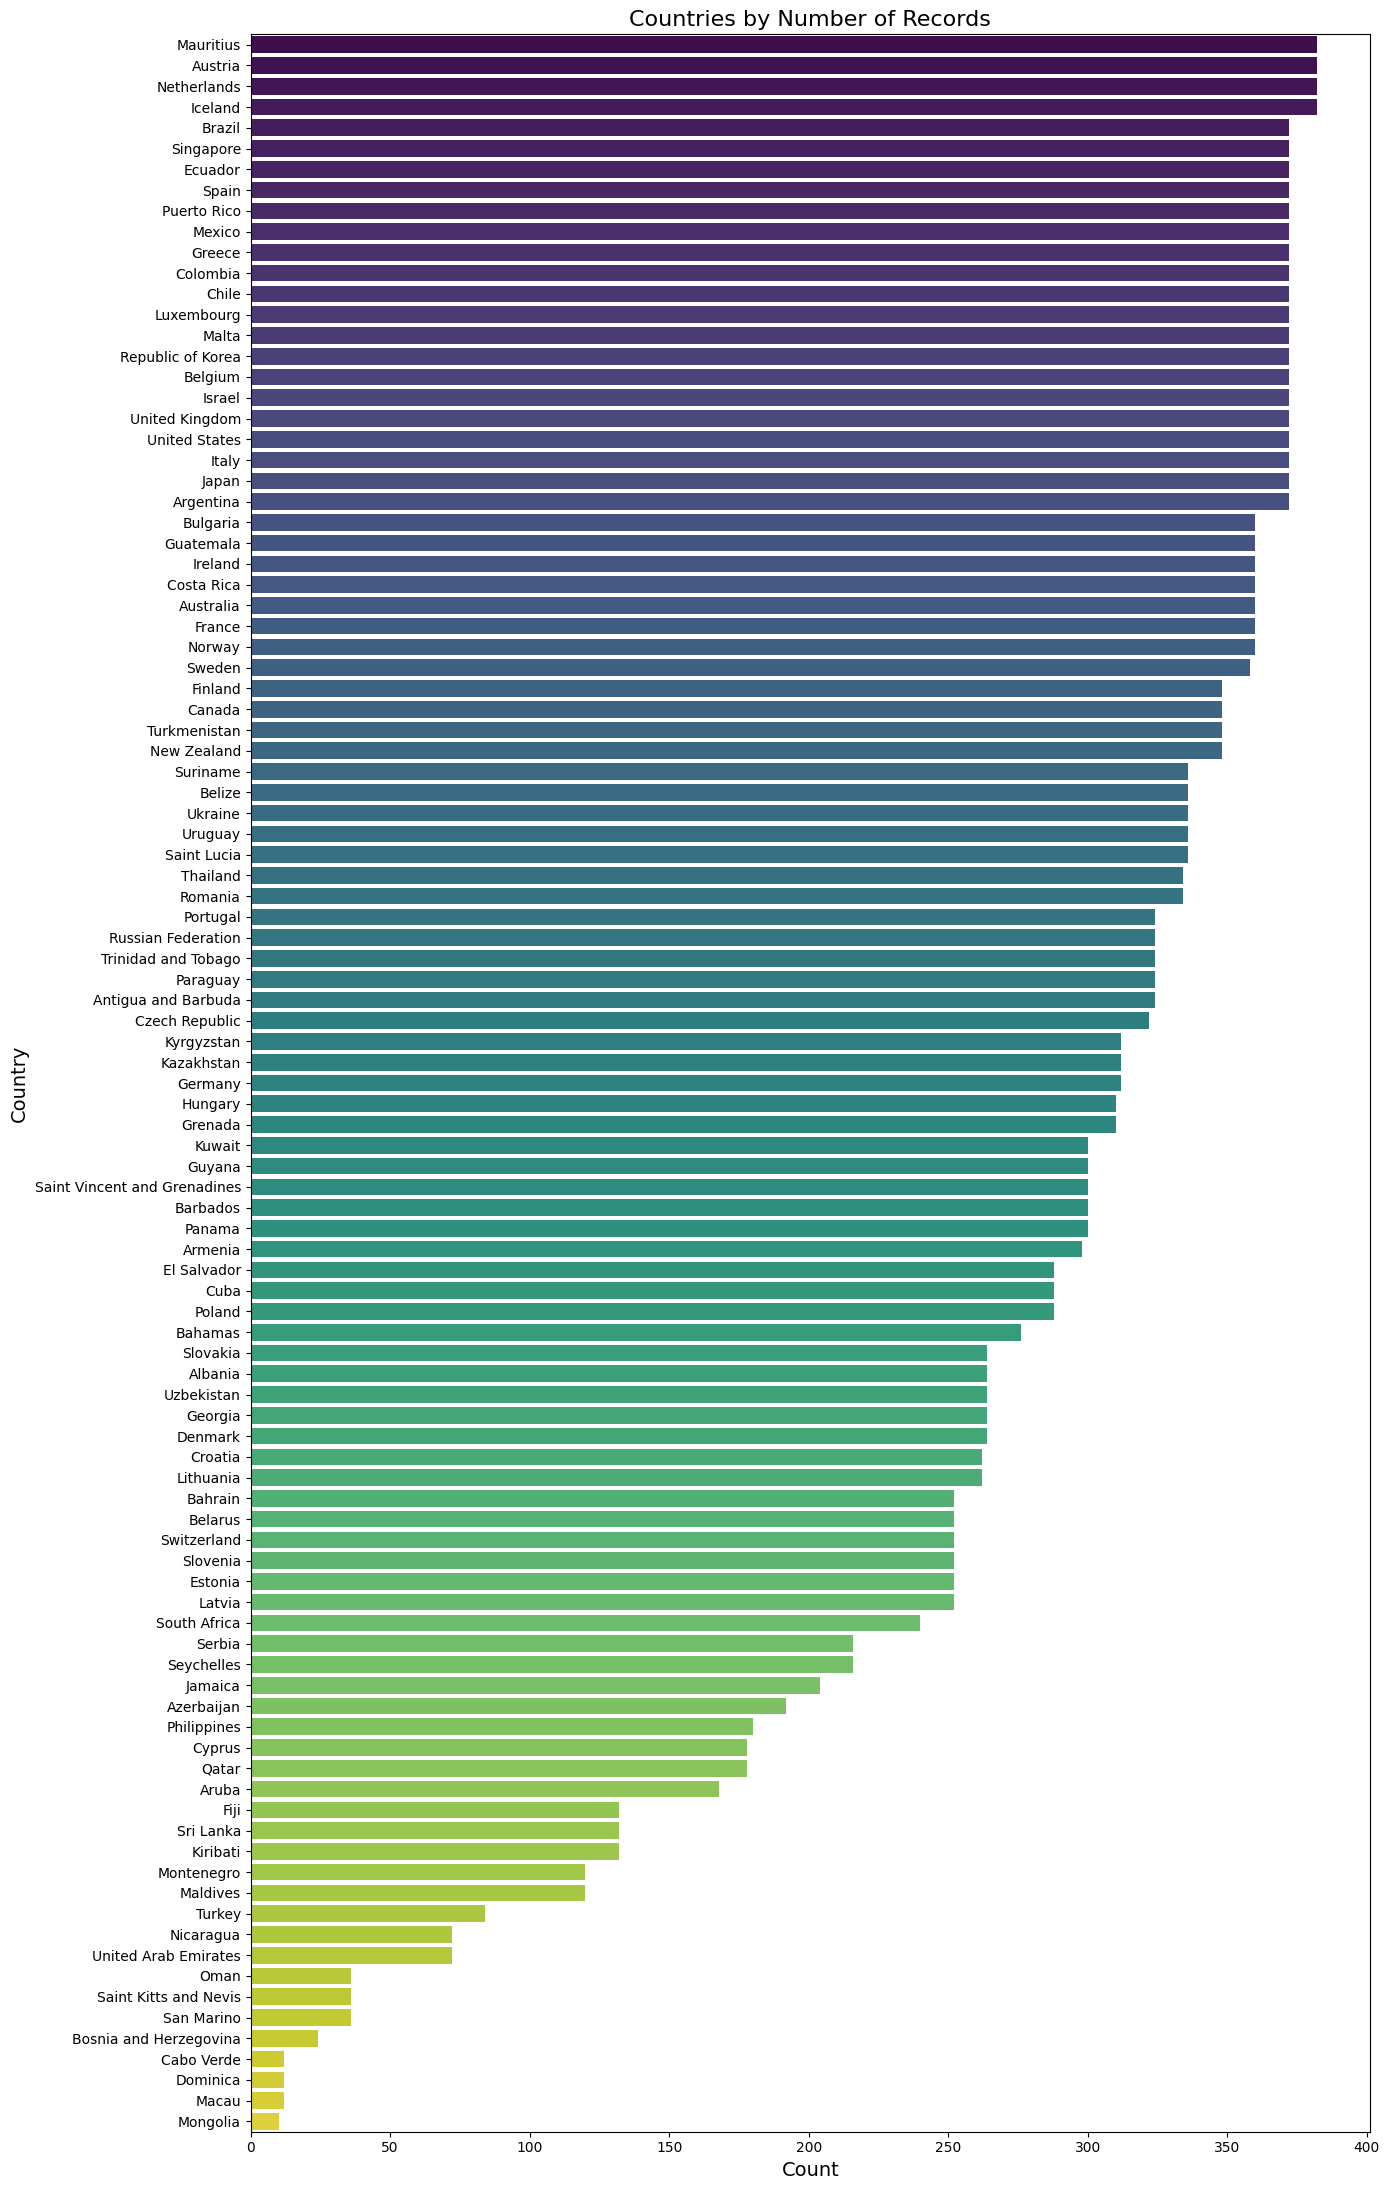

In [53]:
# Distribution of Countries in the Dataset
country_counts = df['country'].value_counts()

plt.figure(figsize=(14, 22))
sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')
plt.title('Countries by Number of Records', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.tight_layout()
plt.show()

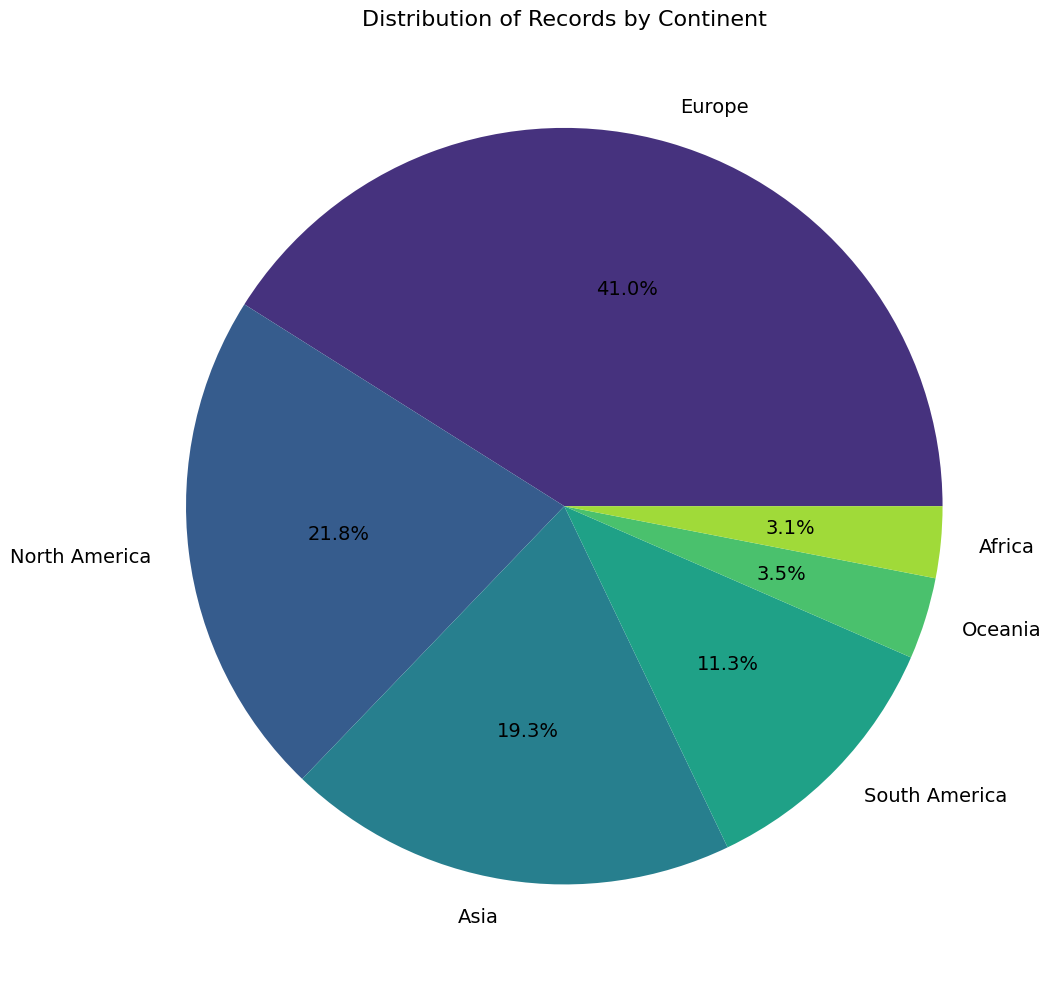

In [52]:
# Map countries to continents
countries = df[df['country'].isin(continent_map.keys())]
countries['continent'] = countries['country'].map(continent_map)
continent_counts = countries['continent'].value_counts()

plt.figure(figsize=(12, 10))
plt.pie(continent_counts, labels=continent_counts.index, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=sns.color_palette('viridis', len(continent_counts)))
plt.title('Distribution of Records by Continent', fontsize=16)
plt.tight_layout()
plt.show()

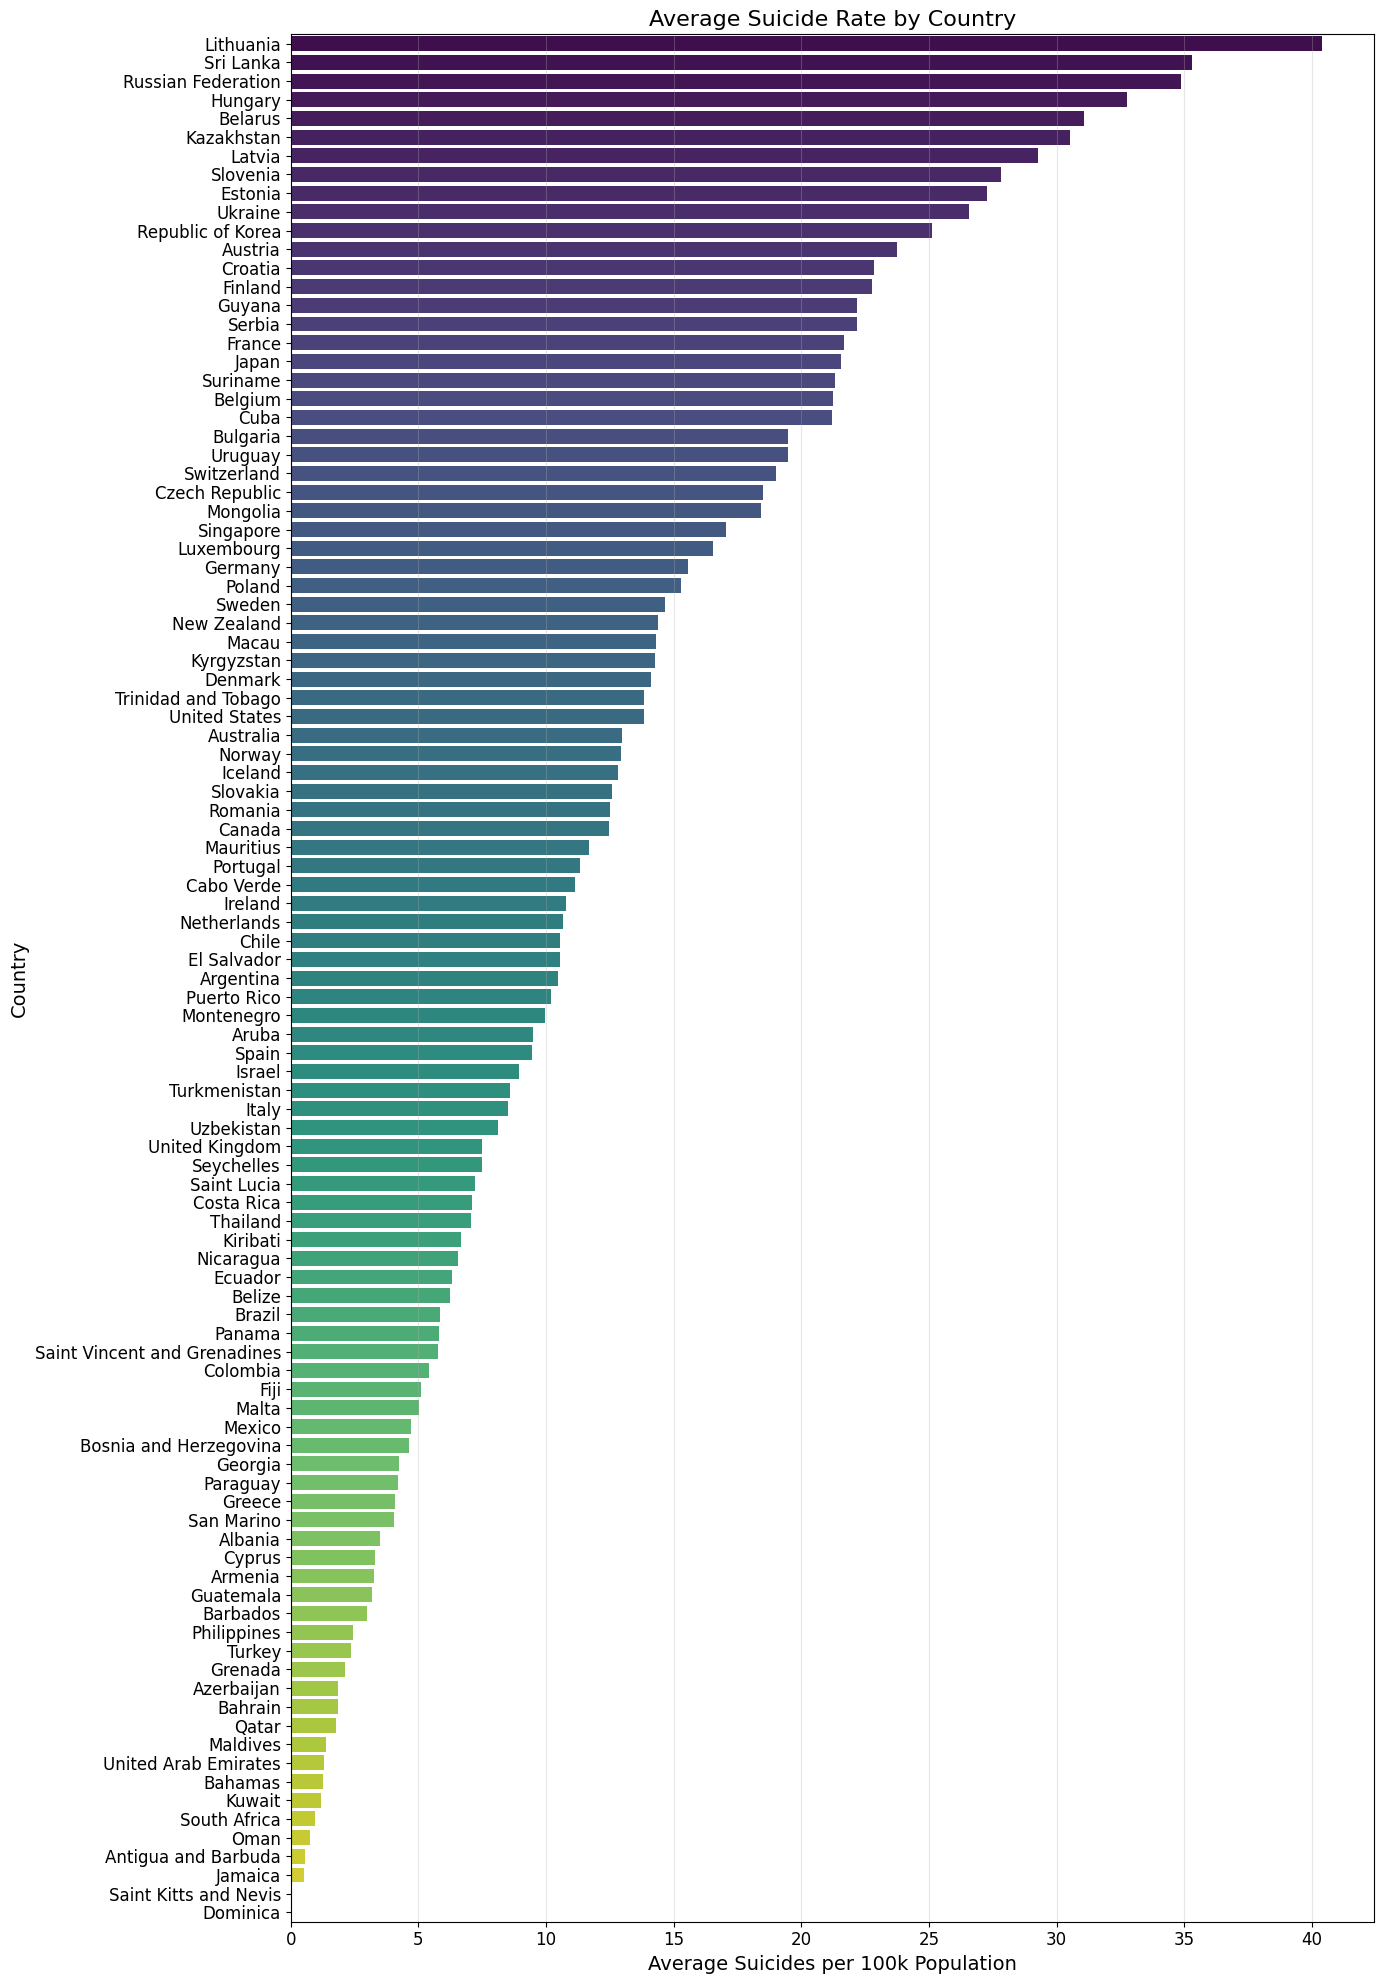

In [ ]:
# Suicide rates distribution by country
country_avg_suicide = df.groupby('country')['suicides/100k pop'].mean().reset_index()
country_avg_suicide.columns = ['country', 'avg_suicide_rate']
country_avg_suicide = country_avg_suicide.sort_values('avg_suicide_rate', ascending=False)

plt.figure(figsize=(14, 20)) 
sns.barplot(x='avg_suicide_rate', y='country', data=country_avg_suicide, palette='viridis')
plt.title('Average Suicide Rate by Country', fontsize=16)
plt.xlabel('Average Suicides per 100k Population', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

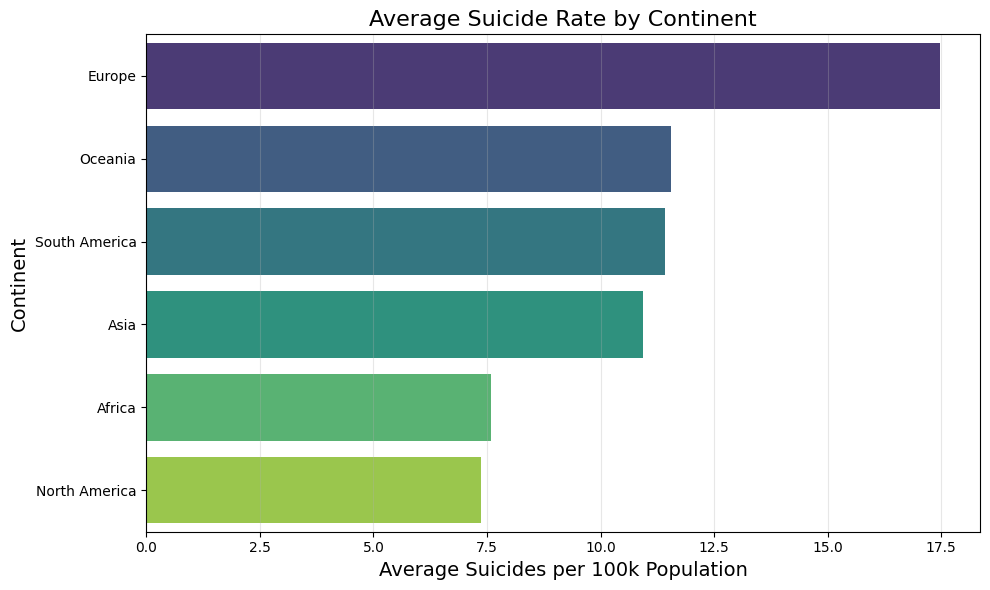

In [ ]:
# Suicide Rate Distribution Map by Continent
subset_countries = df[df['country'].isin(continent_map.keys())].copy()
subset_countries['continent'] = subset_countries['country'].map(continent_map)
continent_avg_suicide = subset_countries.groupby('continent')['suicides/100k pop'].mean().reset_index()
continent_avg_suicide = continent_avg_suicide.sort_values('suicides/100k pop', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='suicides/100k pop', y='continent', data=continent_avg_suicide, palette='viridis')
plt.title('Average Suicide Rate by Continent', fontsize=16)
plt.xlabel('Average Suicides per 100k Population', fontsize=14)
plt.ylabel('Continent', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

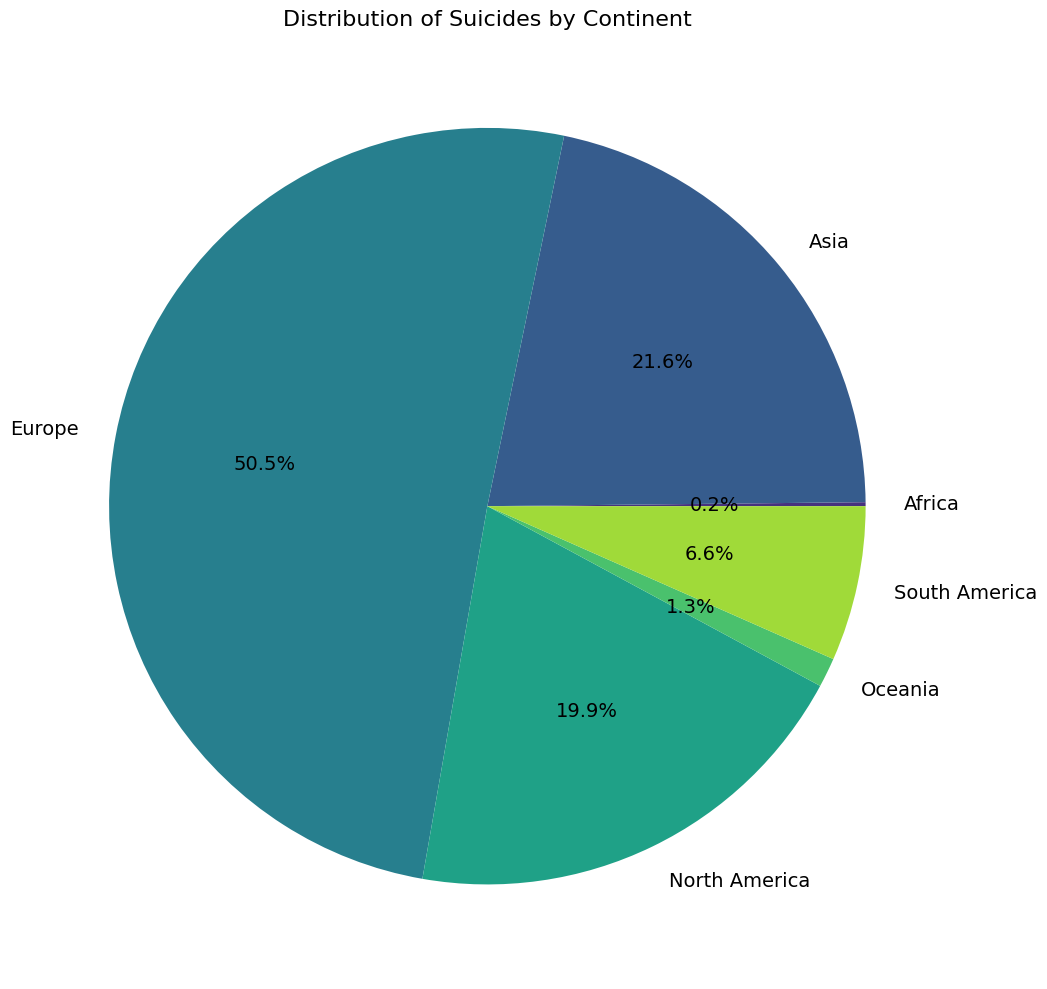

In [54]:
# suicide rates by country mapped to continent
countries = df[df['country'].isin(continent_map.keys())].copy()
countries['continent'] = countries['country'].map(continent_map)
suicides_by_continent = countries.groupby('continent')['suicides_no'].sum()

plt.figure(figsize=(12, 10))
plt.pie(suicides_by_continent, labels=suicides_by_continent.index, autopct='%1.1f%%', 
    textprops={'fontsize': 14}, colors=sns.color_palette('viridis', len(suicides_by_continent)))
plt.title('Distribution of Suicides by Continent', fontsize=16)
plt.tight_layout()
plt.show()

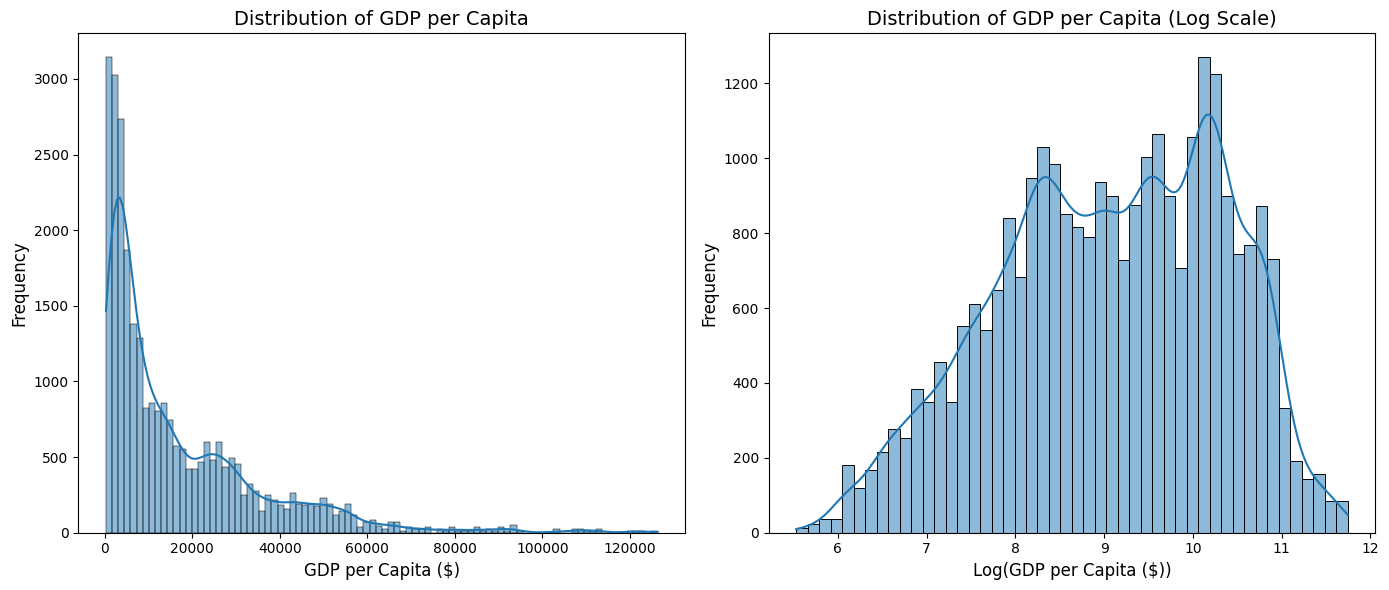

In [55]:
# Distribution of GDP per Capita
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['gdp_per_capita ($)'], kde=True)
plt.title('Distribution of GDP per Capita', fontsize=14)
plt.xlabel('GDP per Capita ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['gdp_per_capita ($)']), kde=True)
plt.title('Distribution of GDP per Capita (Log Scale)', fontsize=14)
plt.xlabel('Log(GDP per Capita ($))', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

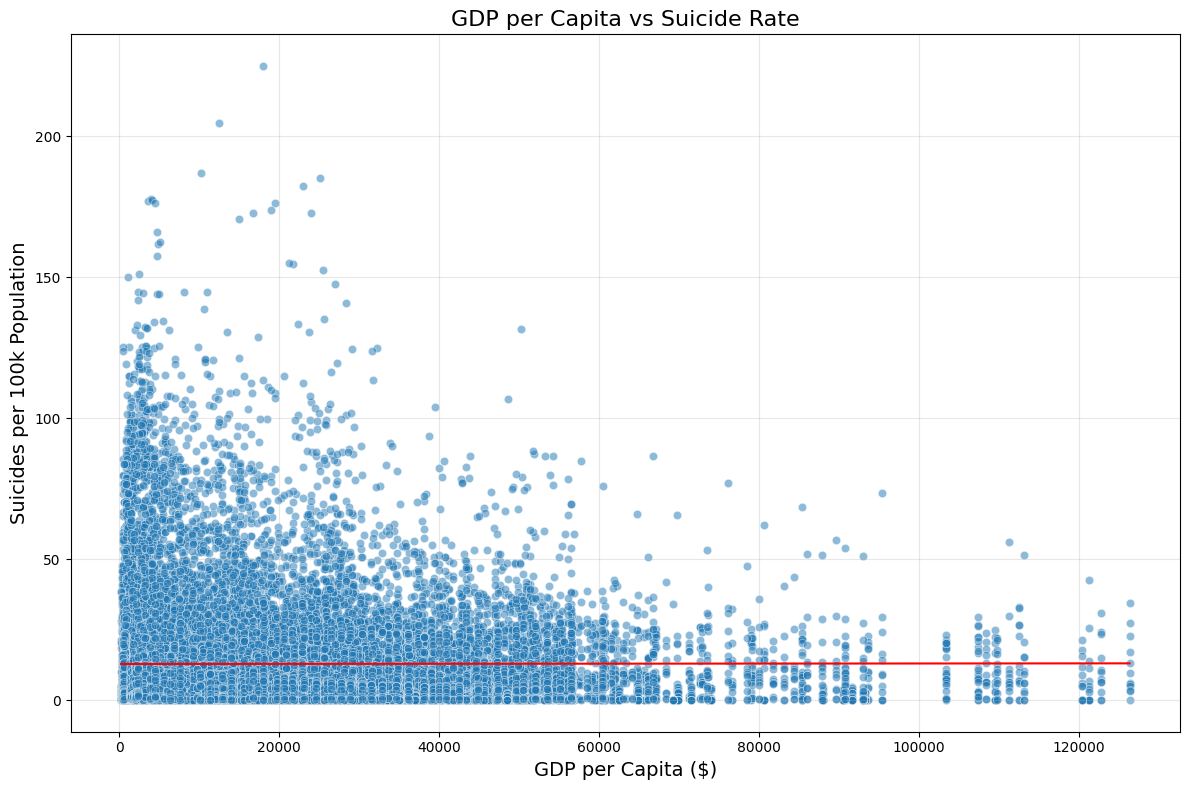

In [ ]:
# Scatter plot of GDP per Capita vs Suicide Rate
plt.figure(figsize=(12, 8))
sns.scatterplot(x='gdp_per_capita ($)', y='suicides/100k pop', data=df, alpha=0.5)
plt.title('GDP per Capita vs Suicide Rate', fontsize=16)
plt.xlabel('GDP per Capita ($)', fontsize=14)
plt.ylabel('Suicides per 100k Population', fontsize=14)
plt.grid(True, alpha=0.3)

# trendline
z = np.polyfit(df['gdp_per_capita ($)'], df['suicides/100k pop'], 1)
p = np.poly1d(z)
plt.plot(sorted(df['gdp_per_capita ($)']), p(sorted(df['gdp_per_capita ($)'])), "r")
plt.tight_layout()
plt.show()

## Exploratory Analysis

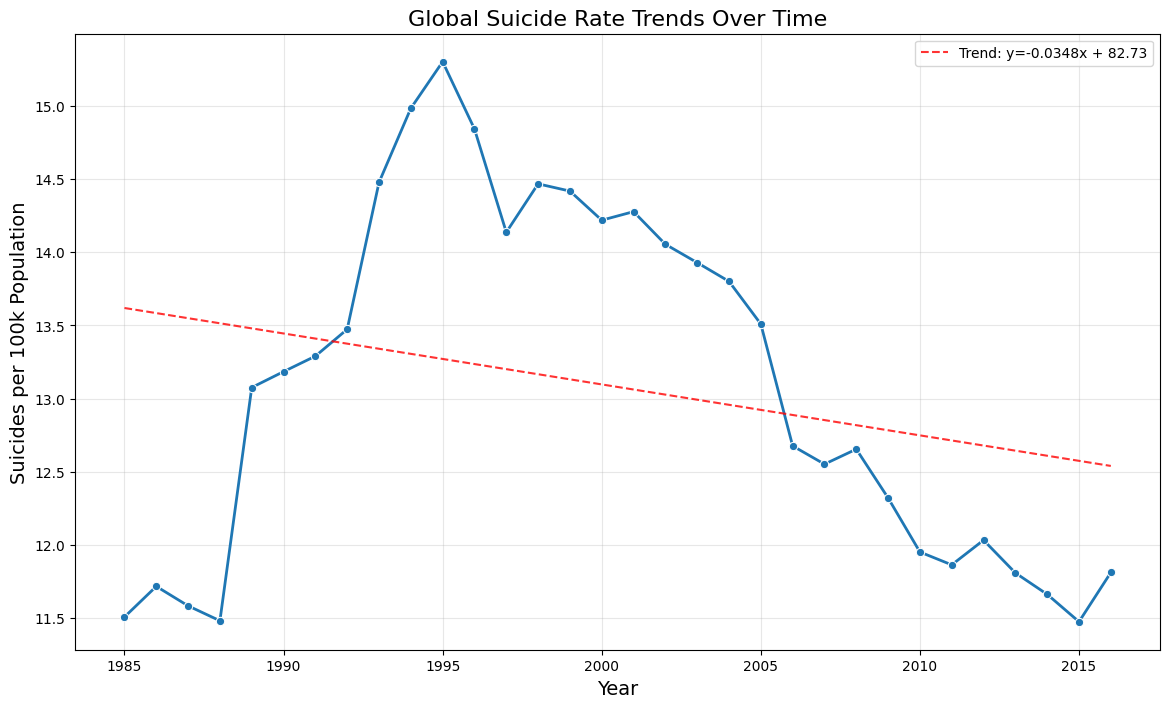

In [ ]:
# Analyze suicide trends over time
yearly_suicides = df.groupby('year')[['suicides_no', 'population']].sum()
yearly_suicides['rate_per_100k'] = yearly_suicides['suicides_no'] / yearly_suicides['population'] * 100000

plt.figure(figsize=(14, 8))
ax = sns.lineplot(x=yearly_suicides.index, y=yearly_suicides['rate_per_100k'], marker='o', linewidth=2)
ax.set_title('Global Suicide Rate Trends Over Time', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Suicides per 100k Population', fontsize=14)
plt.grid(True, alpha=0.3)

# trendline
z = np.polyfit(yearly_suicides.index, yearly_suicides['rate_per_100k'], 1)
p = np.poly1d(z)
plt.plot(yearly_suicides.index, p(yearly_suicides.index), "r--", alpha=0.8, label=f"Trend: y={z[0]:.4f}x + {z[1]:.2f}")
plt.legend()
plt.show()

In [35]:
df['age'].value_counts()

age
15-24 years    4642
35-54 years    4642
75+ years      4642
25-34 years    4642
55-74 years    4642
5-14 years     4610
Name: count, dtype: int64

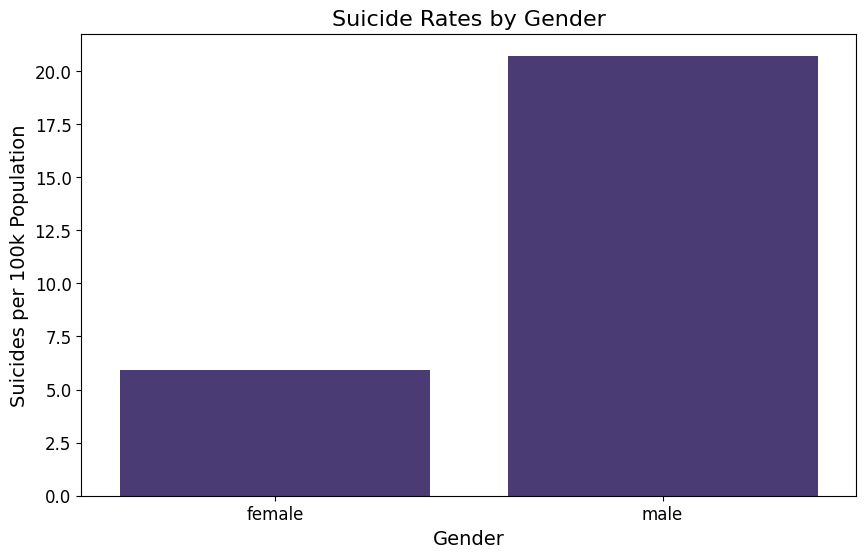

In [86]:
# Gender-based suicide rates
gender_suicide = df.groupby('sex')[['suicides_no', 'population']].sum()
gender_suicide['rate_per_100k'] = gender_suicide['suicides_no'] / gender_suicide['population'] * 100000

plt.figure(figsize=(10, 6))
sns.barplot(x=gender_suicide.index, y=gender_suicide['rate_per_100k'])
plt.title('Suicide Rates by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Suicides per 100k Population', fontsize=14)
plt.show()

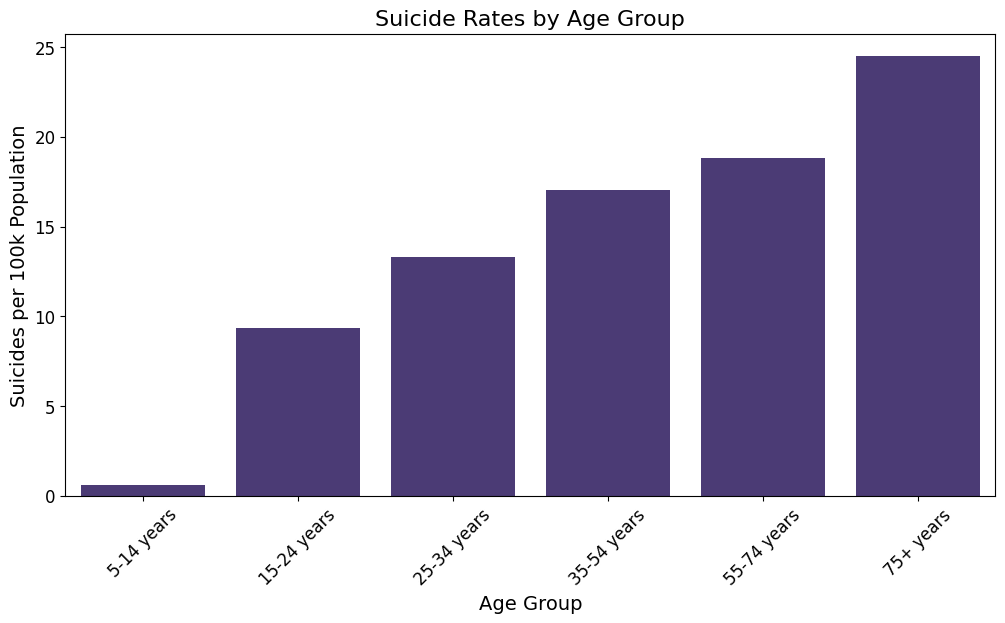

In [85]:
# Age group analysis in ascending order
age_order = ["5-14 years", "15-24 years", "25-34 years", "35-54 years", "55-74 years", "75+ years"]
age_suicide = df.groupby('age')[['suicides_no', 'population']].sum()
age_suicide['rate_per_100k'] = age_suicide['suicides_no'] / age_suicide['population'] * 100000
age_suicide = age_suicide.reindex(age_order)

plt.figure(figsize=(12, 6))
sns.barplot(x=age_suicide.index, y=age_suicide['rate_per_100k'])
plt.title('Suicide Rates by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Suicides per 100k Population', fontsize=14)
plt.xticks(rotation=45)
plt.show()

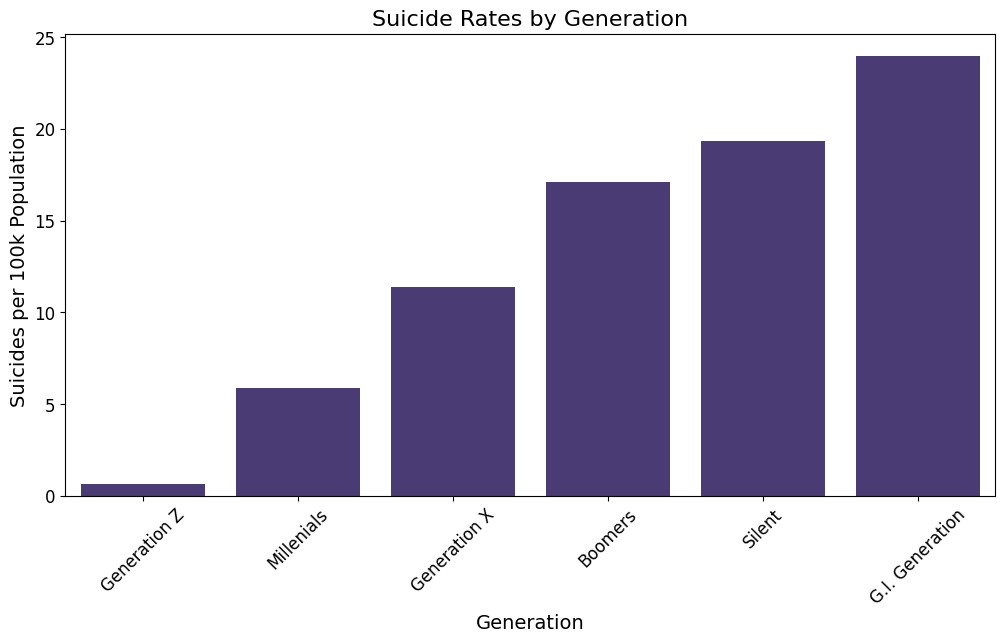

In [87]:
# Generation analysis in ascending order
gen_order = ["Generation Z", "Millenials", "Generation X", "Boomers", "Silent", "G.I. Generation"]
gen_suicide = df.groupby('generation')[['suicides_no', 'population']].sum()
gen_suicide['rate_per_100k'] = gen_suicide['suicides_no'] / gen_suicide['population'] * 100000
gen_suicide = gen_suicide.reindex(gen_order)

plt.figure(figsize=(12, 6))
sns.barplot(x=gen_suicide.index, y=gen_suicide['rate_per_100k'])
plt.title('Suicide Rates by Generation', fontsize=16)
plt.xlabel('Generation', fontsize=14)
plt.ylabel('Suicides per 100k Population', fontsize=14)
plt.xticks(rotation=45)
plt.show()

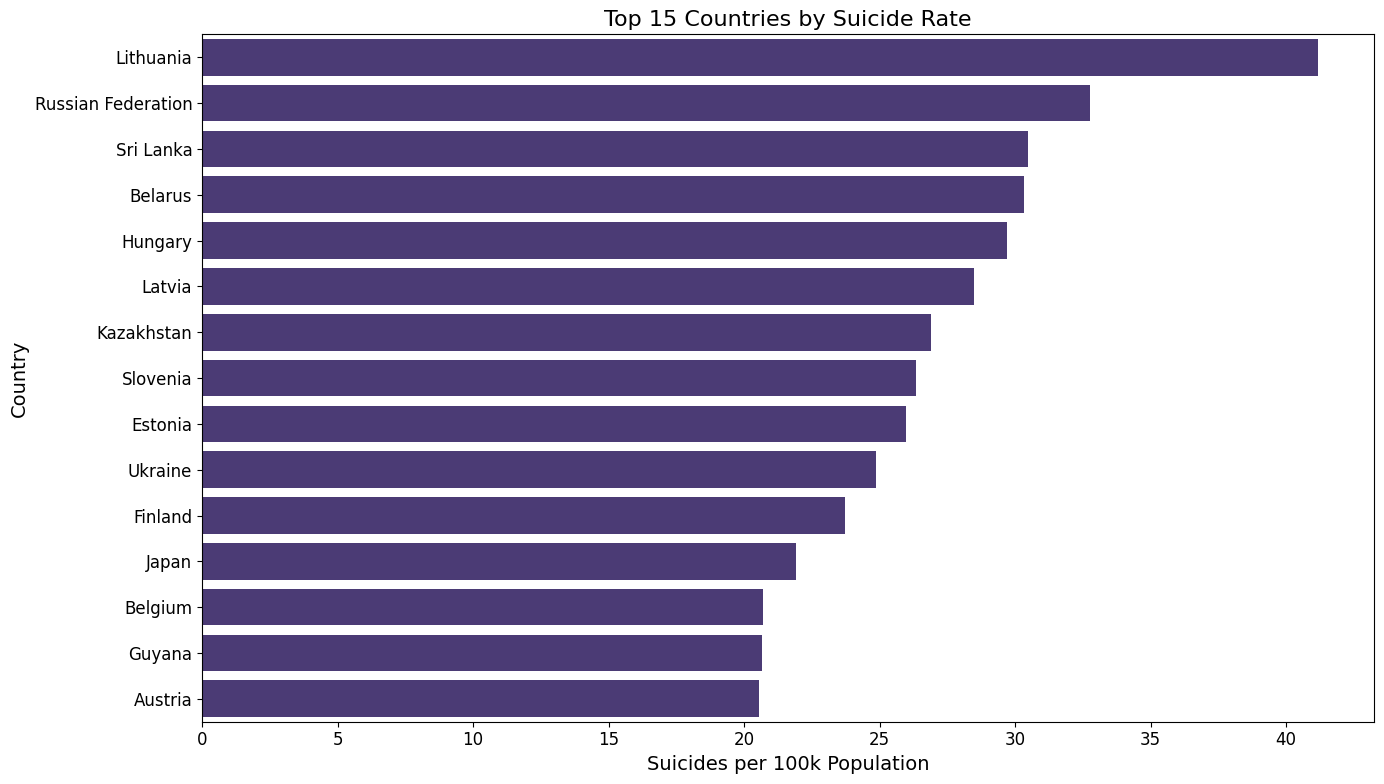

In [88]:
# Geographic analysis - Top 15 countries by suicide rate
country_suicide = df.groupby('country')[['suicides_no', 'population']].sum()
country_suicide['rate_per_100k'] = country_suicide['suicides_no'] / country_suicide['population'] * 100000
top_countries = country_suicide.sort_values('rate_per_100k', ascending=False).head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_countries['rate_per_100k'], y=top_countries.index)
plt.title('Top 15 Countries by Suicide Rate', fontsize=16)
plt.xlabel('Suicides per 100k Population', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.tight_layout()
plt.show()

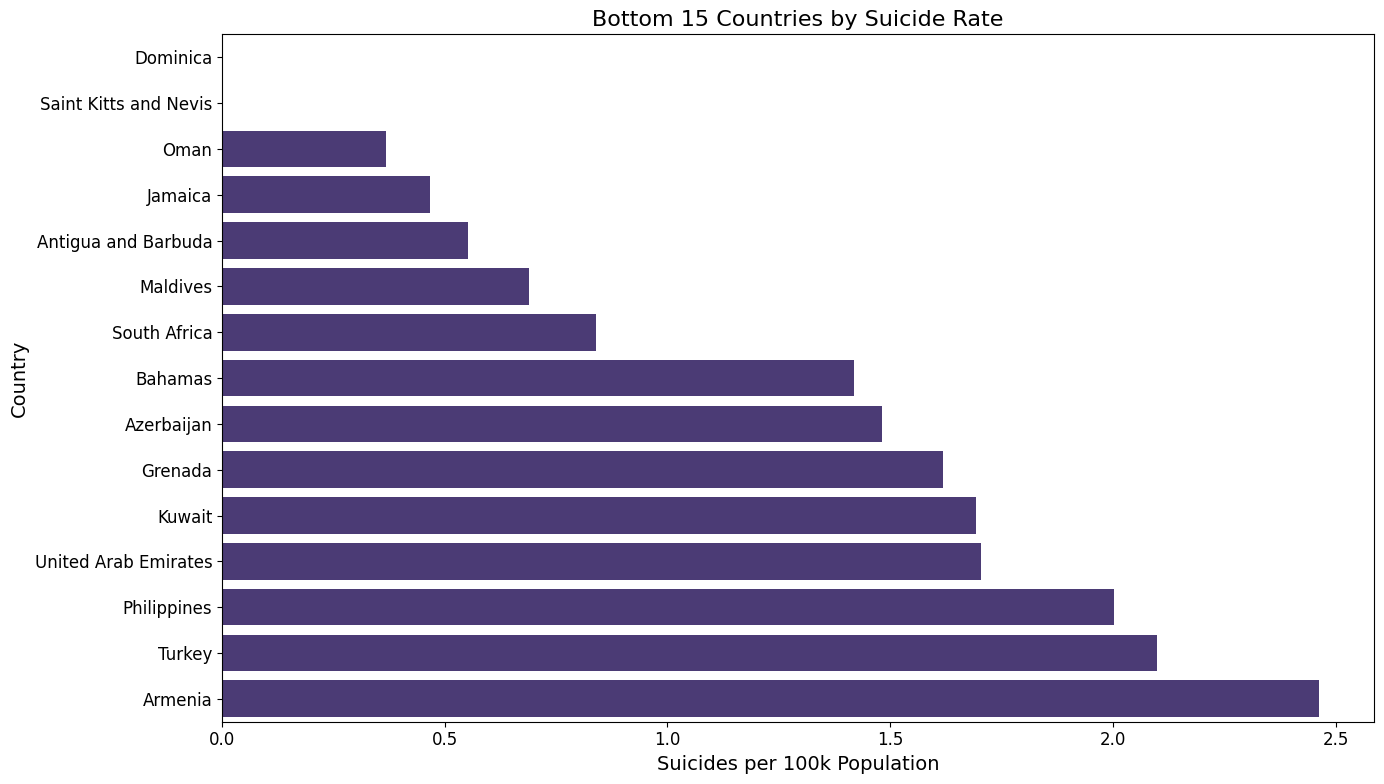

In [89]:
# Bottom 15 countries by suicide rate
bottom_countries = country_suicide.sort_values('rate_per_100k').head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x=bottom_countries['rate_per_100k'], y=bottom_countries.index)
plt.title('Bottom 15 Countries by Suicide Rate', fontsize=16)
plt.xlabel('Suicides per 100k Population', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.tight_layout()
plt.show()

## Key Performance Indicators (KPIs)

In [44]:
# 1. Overall Suicide Rate KPI: Global suicide rate per 100k population
overall_rate = df['suicides_no'].sum() / df['population'].sum() * 100000

# 2. Gender Disparity KPI: Male-to-Female suicide rate ratio
male_rate = df[df['sex'] == 'male']['suicides_no'].sum() / df[df['sex'] == 'male']['population'].sum() * 100000
female_rate = df[df['sex'] == 'female']['suicides_no'].sum() / df[df['sex'] == 'female']['population'].sum() * 100000
gender_disparity = male_rate / female_rate if female_rate != 0 else np.inf

# 3. Age Risk KPI: Highest risk age group's rate compared to overall
age_group_rates = df.groupby('age')[['suicides_no', 'population']].sum()
age_group_rates['rate_per_100k'] = age_group_rates['suicides_no'] / age_group_rates['population'] * 100000
highest_risk_age = age_group_rates['rate_per_100k'].idxmax()
age_risk_ratio = age_group_rates.loc[highest_risk_age, 'rate_per_100k'] / overall_rate if overall_rate != 0 else np.inf

# 4. Economic Impact KPI: Correlation between GDP per capita and suicide rate
country_year_gdp = df.groupby(['country','year'])[['suicides_no','population','gdp_per_capita ($)']].sum().reset_index()
country_year_gdp['rate_per_100k'] = country_year_gdp['suicides_no'] / country_year_gdp['population'] * 100000
gdp_correlation = country_year_gdp['gdp_per_capita ($)'].corr(country_year_gdp['rate_per_100k'])
    
# 5. Trend KPI: Calculate average year-over-year percentage change in suicide rates from 1995 onward
trend_data = yearly_suicides.loc[yearly_suicides.index <= 1995, 'rate_per_100k']
avg_yearly_inc_change_pct = trend_data.pct_change().dropna().mean() * 100
trend_data = yearly_suicides.loc[yearly_suicides.index >= 1995, 'rate_per_100k']
avg_yearly_dec_change_pct = trend_data.pct_change().dropna().mean() * 100


print("KPI:")
print(f"Overall Suicide Rate (per 100k): {overall_rate:.2f}")
print(f"Gender Disparity Ratio (M:F): {gender_disparity:.2f}")
print(f"Age Risk Ratio ({highest_risk_age} vs Overall): {age_risk_ratio:.2f}")
print(f"GDP-Suicide Rate Correlation: {gdp_correlation:.2f}")
print(f"Average Yearly Change in Suicide Rate Up to 1995: {avg_yearly_inc_change_pct:.2f}%")
print(f"Average Yearly Change in Suicide Rate Since 1995: {avg_yearly_dec_change_pct:.2f}%")


KPI:
Overall Suicide Rate (per 100k): 13.15
Gender Disparity Ratio (M:F): 3.49
Age Risk Ratio (75+ years vs Overall): 1.86
GDP-Suicide Rate Correlation: 0.06
Average Yearly Change in Suicide Rate Up to 1995: 2.98%
Average Yearly Change in Suicide Rate Since 1995: -1.20%


## Advanced Statistical Analysis

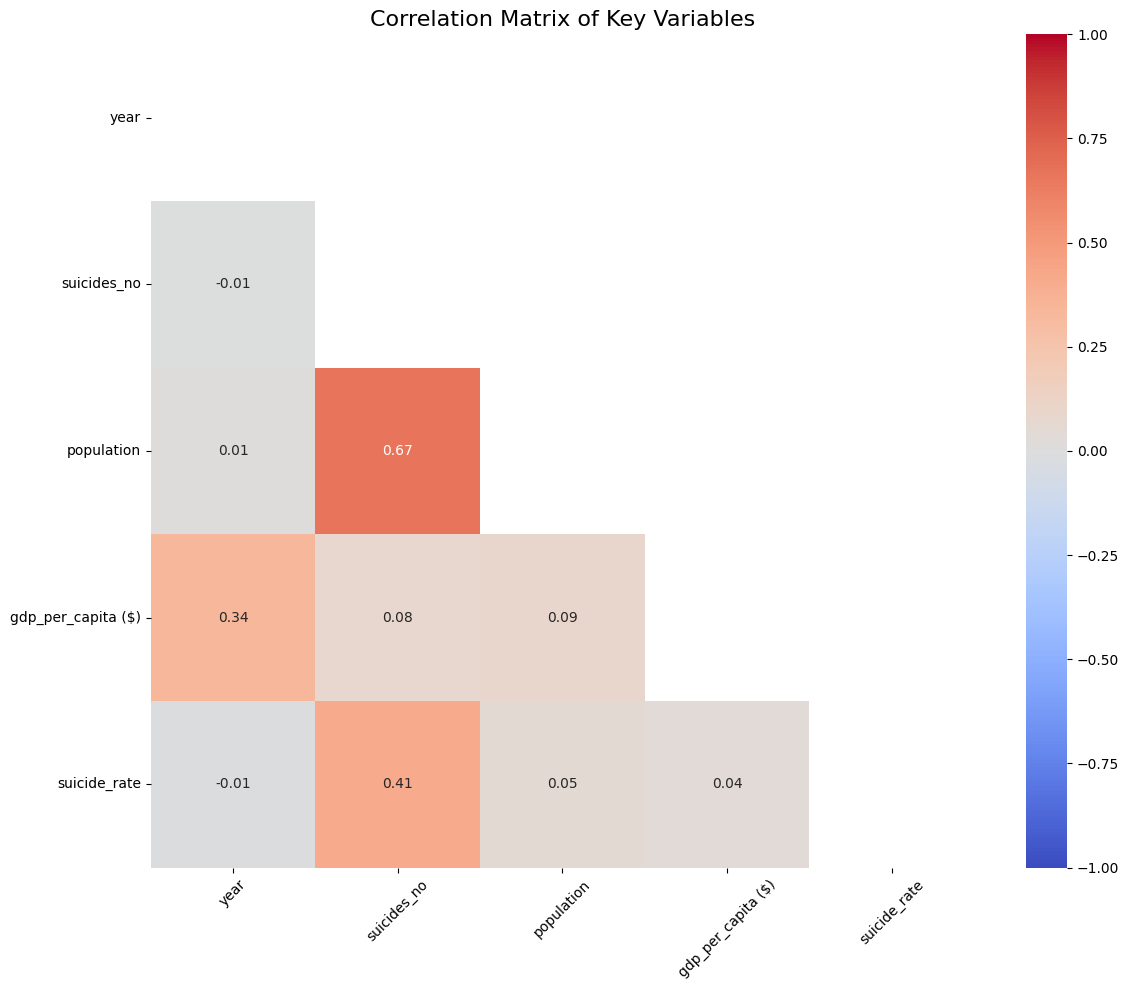

In [14]:
# correlation analysis
agg_df = df.groupby(['country', 'year', 'sex'])[['suicides_no', 'population', 'gdp_per_capita ($)']].sum().reset_index()
agg_df['suicide_rate'] = agg_df['suicides_no'] / agg_df['population'] * 100000
corr_cols = ['year', 'suicides_no', 'population', 'gdp_per_capita ($)', 'suicide_rate']
corr_matrix = agg_df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Key Variables', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Multiple regression analysis to identify factors influencing suicide rates
regression_df = agg_df.copy()
regression_df = pd.get_dummies(regression_df, columns=['sex'], drop_first=True)

X = regression_df[['year', 'gdp_per_capita ($)', 'sex_male']]
X['sex_male'] = X['sex_male'].astype(int)
y = regression_df['suicide_rate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_const = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           suicide_rate   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     580.3
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.91e-320
Time:                        14:16:37   Log-Likelihood:                -17661.
No. Observations:                4642   AIC:                         3.533e+04
Df Residuals:                    4638   BIC:                         3.536e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9411      0.160     74.839      0.0

## Predictive Modeling

Random Forest Model Performance:
RMSE: 2.29
R² Score: 0.9687


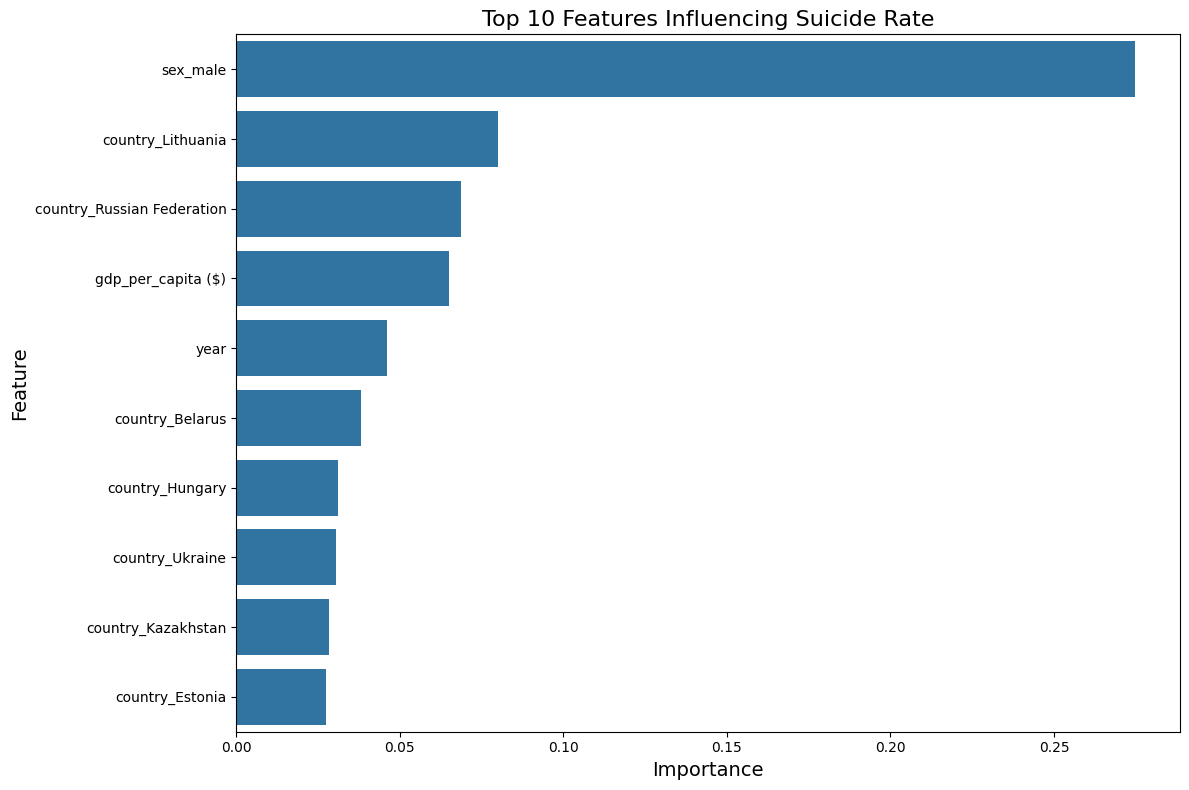

In [60]:
model_df = agg_df.copy()
model_df = pd.get_dummies(model_df, columns=['country', 'sex'], drop_first=True)

features = ['year', 'gdp_per_capita ($)'] + [col for col in model_df.columns if col.startswith('country_') or col.startswith('sex_')]
X = model_df[features]
y = model_df['suicide_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, rf_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_preds)

print(f"Random Forest Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
top_features = feature_importances.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Features Influencing Suicide Rate', fontsize=16)
plt.xlabel('Importance', fontsize=14) 
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [52]:
# LSTM prep
ts_data = yearly_suicides['rate_per_100k']
scaler_lstm = MinMaxScaler()
scaled_data = scaler_lstm.fit_transform(ts_data.values.reshape(-1, 1))

time_step = 5 # Lookback period
forecast_steps = 5

scaled_train = scaled_data[:-forecast_steps]
scaled_test = scaled_data[-forecast_steps-time_step:]

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=time_step, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=time_step, batch_size=1)

# Training and Evaluation
lstm_model_train = Sequential()
lstm_model_train.add(LSTM(50, activation='relu', input_shape=(time_step, 1)))
lstm_model_train.add(Dense(1))
lstm_model_train.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_train.fit(train_generator, epochs=100, verbose=0)

lstm_test_pred_scaled = lstm_model_train.predict(test_generator)
lstm_test_pred = scaler_lstm.inverse_transform(lstm_test_pred_scaled)

actual_test_data = ts_data.values[-forecast_steps:]

lstm_rmse = np.sqrt(mean_squared_error(actual_test_data, lstm_test_pred))
lstm_mae = mean_absolute_error(actual_test_data, lstm_test_pred)

# retrain on full data
full_generator = TimeseriesGenerator(scaled_data, scaled_data, length=time_step, batch_size=1)
lstm_model_full = Sequential()
lstm_model_full.add(LSTM(50, activation='relu', input_shape=(time_step, 1)))
lstm_model_full.add(Dense(1))
lstm_model_full.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_full.fit(full_generator, epochs=100, verbose=0)

# forecasting
lstm_forecast_scaled = []
current_batch = scaled_data[-time_step:].reshape((1, time_step, 1))

for i in range(forecast_steps):
    current_pred = lstm_model_full.predict(current_batch)[0]
    lstm_forecast_scaled.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

lstm_forecast_values = scaler_lstm.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1, 1)).flatten()
lstm_forecast_index = np.arange(ts_data.index[-1] + 1, ts_data.index[-1] + forecast_steps + 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Model Evaluation Metrics (Test Set) ---
LSTM RMSE:  0.22, MAE: 0.20


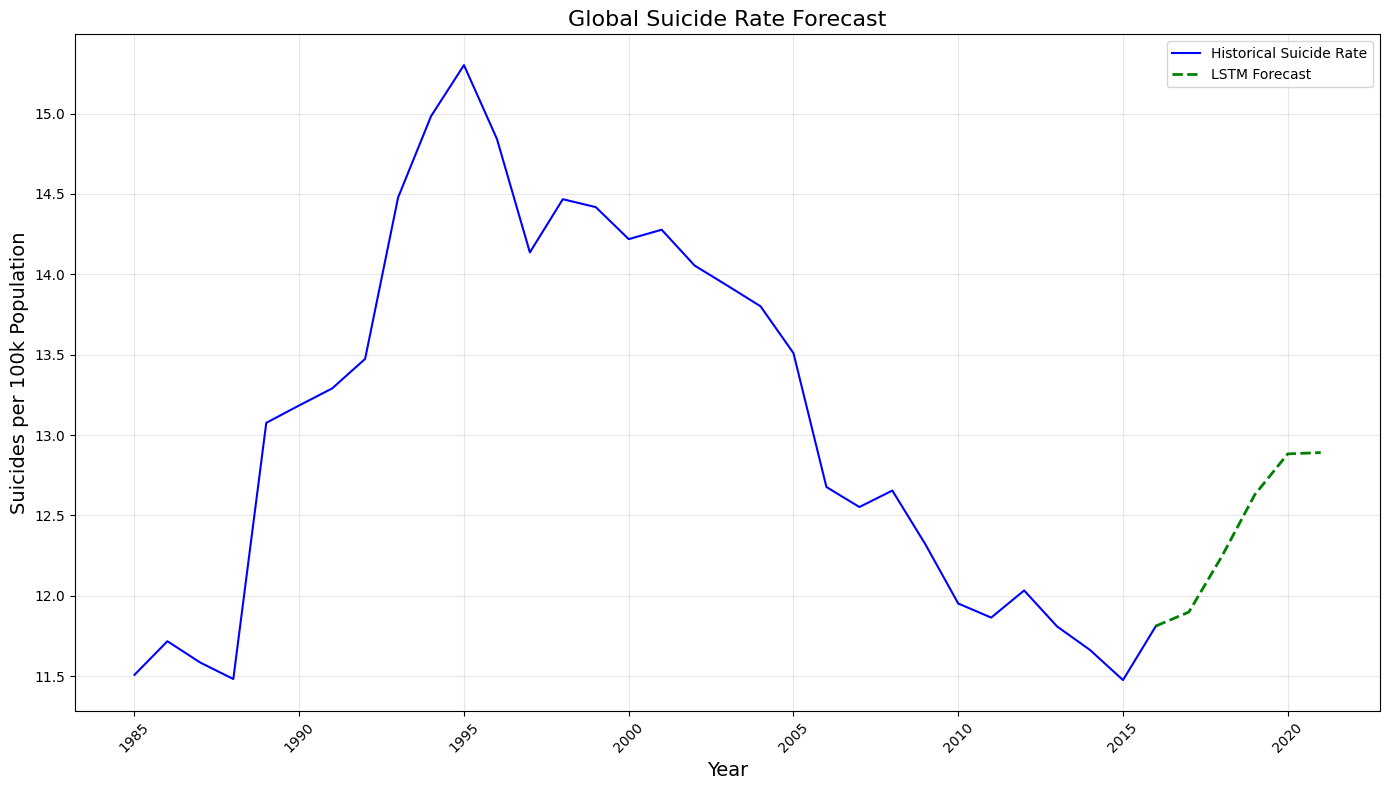

In [ ]:
print("Model Evaluation Metrics (Test Set):")
print(f"LSTM RMSE:  {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

last_hist_year = ts_data.index[-1]
last_hist_value = ts_data.values[-1]

plot_lstm_index = np.insert(lstm_forecast_index, 0, last_hist_year)
plot_lstm_values = np.insert(lstm_forecast_values, 0, last_hist_value)

plt.figure(figsize=(14, 8))
plt.plot(ts_data.index, ts_data.values, 'b-', label='Historical Suicide Rate')
plt.plot(plot_lstm_index, plot_lstm_values, 'g--', linewidth=2, label='LSTM Forecast')
plt.title('Global Suicide Rate Forecast', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Suicides per 100k Population', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()